In [4]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
import seaborn as sns
import lightgbm as lgb
import csv

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 1.Load dataset


In [5]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
turns = pd.read_csv('/content/turns.csv', sep=",", engine="python", on_bad_lines="skip")
sub = pd.read_csv('/content/sample_submission.csv')
games = pd.read_csv('/content/games.csv')

# 2. Data Cleaning

Rename columns

In [6]:
train = train.rename(columns=str.lower)
test  = test.rename(columns=str.lower)
turns = turns.rename(columns=str.lower)
games = games.rename(columns=str.lower)

In [7]:
brief_df = pd.concat([train, test], axis=0)
brief_df = brief_df.sort_values(["game_id"])
bots = ["BetterBot", "STEEBot", "HastyBot"]


user_df = brief_df[~brief_df["nickname"].isin(bots)]
user_df = user_df.rename(
    columns={"nickname": "user_name", "score": "user_score", "rating": "user_rating"}
)
bot_df = brief_df[brief_df["nickname"].isin(bots)]

bot_df = bot_df.rename(
    columns={"nickname": "bot_name", "score": "bot_score", "rating": "bot_rating"}
)

main_df = pd.merge(user_df, bot_df, on="game_id")
main_df.head()

,game_id,user_name,user_score,user_rating,bot_name,bot_score,bot_rating
0,1,stevy,429,1500.0,BetterBot,335,1637.0
1,2,Super,488,NaN,BetterBot,401,2000.0
2,3,davidavid,440,1811.0,BetterBot,318,2071.0
3,4,Inandoutworker,119,1473.0,BetterBot,478,1936.0
4,5,stevy,325,1500.0,STEEBot,427,1844.0


In [8]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72773 entries, 0 to 72772
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   game_id      72773 non-null  int64  
 1   user_name    72773 non-null  object 
 2   user_score   72773 non-null  int64  
 3   user_rating  50410 non-null  float64
 4   bot_name     72773 non-null  object 
 5   bot_score    72773 non-null  int64  
 6   bot_rating   72773 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.9+ MB


In [9]:
main_df["user_freq"] = main_df.groupby("user_name")["user_name"].transform("count")
encode_bots = LabelEncoder()
main_df["bot_name"] = encode_bots.fit_transform(main_df["bot_name"])
main_df.head()

,game_id,user_name,user_score,user_rating,bot_name,bot_score,bot_rating,user_freq
0,1,stevy,429,1500.0,0,335,1637.0,410
1,2,Super,488,NaN,0,401,2000.0,140
2,3,davidavid,440,1811.0,0,318,2071.0,254
3,4,Inandoutworker,119,1473.0,0,478,1936.0,205
4,5,stevy,325,1500.0,2,427,1844.0,410


Check for missing labels

In [10]:
missing_cols = main_df.columns[main_df.isnull().any()].tolist()
print(f' {missing_cols} ')

 ['user_rating'] 


In [11]:
train_df = main_df[~main_df['user_rating'].isna()].reset_index(drop=True)
train_df.head()

,game_id,user_name,user_score,user_rating,bot_name,bot_score,bot_rating,user_freq
0,1,stevy,429,1500.0,0,335,1637.0,410
1,3,davidavid,440,1811.0,0,318,2071.0,254
2,4,Inandoutworker,119,1473.0,0,478,1936.0,205
3,5,stevy,325,1500.0,2,427,1844.0,410
4,6,HivinD,378,2029.0,2,427,2143.0,592


In [12]:
test_df  = main_df[main_df['user_rating'].isna()].reset_index(drop=True)
test_df.head()

,game_id,user_name,user_score,user_rating,bot_name,bot_score,bot_rating,user_freq
0,2,Super,488,NaN,0,401,2000.0,140
1,7,Priya1,379,NaN,2,377,2082.0,166
2,11,TileRunner,462,NaN,2,334,1829.0,269
3,14,Anfield223,359,NaN,2,403,2136.0,65
4,27,friesbasil,456,NaN,1,453,2258.0,528


***
# 3. Some EDA

In [13]:
train.shape

(100820, 4)

In [14]:
test.shape

(44726, 4)

In [15]:
turns.shape

(2005498, 9)

In [16]:
games.shape

(72773, 12)

Check for missing values

In [17]:
print("Games missing values:\n", games.isnull().sum())
print("\nTurns missing values:\n", turns.isnull().sum())
print("\nTrain missing values:\n", train.isnull().sum())
print("\nTest missing values:\n", test.isnull().sum())

Games missing values:
 game_id                  0
first                    0
time_control_name        0
game_end_reason          0
winner                   0
created_at               0
lexicon                  0
initial_time_seconds     0
increment_seconds        0
rating_mode              0
max_overtime_minutes     0
game_duration_seconds    0
dtype: int64

Turns missing values:
 game_id             0
turn_number         0
nickname            0
rack            69390
location       132239
move              454
points              0
score               0
turn_type         395
dtype: int64

Train missing values:
 game_id     0
nickname    0
score       0
rating      0
dtype: int64

Test missing values:
 game_id         0
nickname        0
score           0
rating      22363
dtype: int64


Statistics


In [18]:
print("Games summary:\n", games.describe())
print("\nTurns summary:\n", turns.describe())
print("\nTrain summary:\n", train.describe())
print("\nTest summary:\n", test.describe())

Games summary:
             game_id        winner  initial_time_seconds  increment_seconds  \
count  72773.000000  72773.000000          72773.000000        72773.00000   
mean   36387.000000      0.350734           1198.034230            0.22856   
std    21007.899907      0.484859            713.185219            2.54802   
min        1.000000     -1.000000             15.000000            0.00000   
25%    18194.000000      0.000000            900.000000            0.00000   
50%    36387.000000      0.000000           1200.000000            0.00000   
75%    54580.000000      1.000000           1200.000000            0.00000   
max    72773.000000      1.000000           3600.000000           60.00000   

       max_overtime_minutes  game_duration_seconds  
count          72773.000000           72773.000000  
mean               2.143707             484.069347  
std                2.989853             333.563128  
min                0.000000               7.962989  
25%             

distribution of player ratings

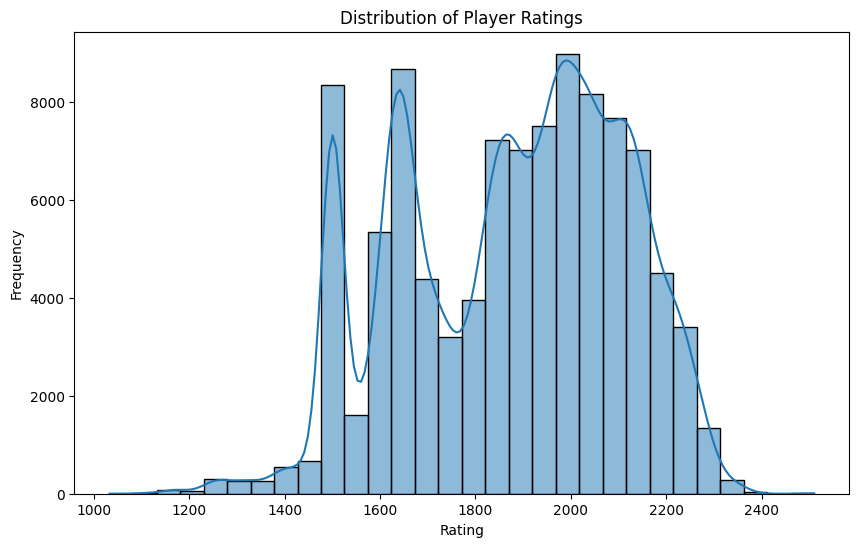

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(train['rating'], bins=30, kde=True)
plt.title('Distribution of Player Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

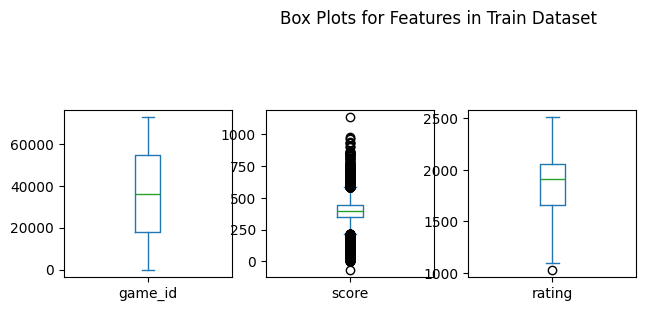

In [20]:
train.plot(kind='box', subplots=True, layout=(4, 4), sharex=False, sharey=False, figsize=(10, 10))
plt.suptitle('Box Plots for Features in Train Dataset')
plt.show()


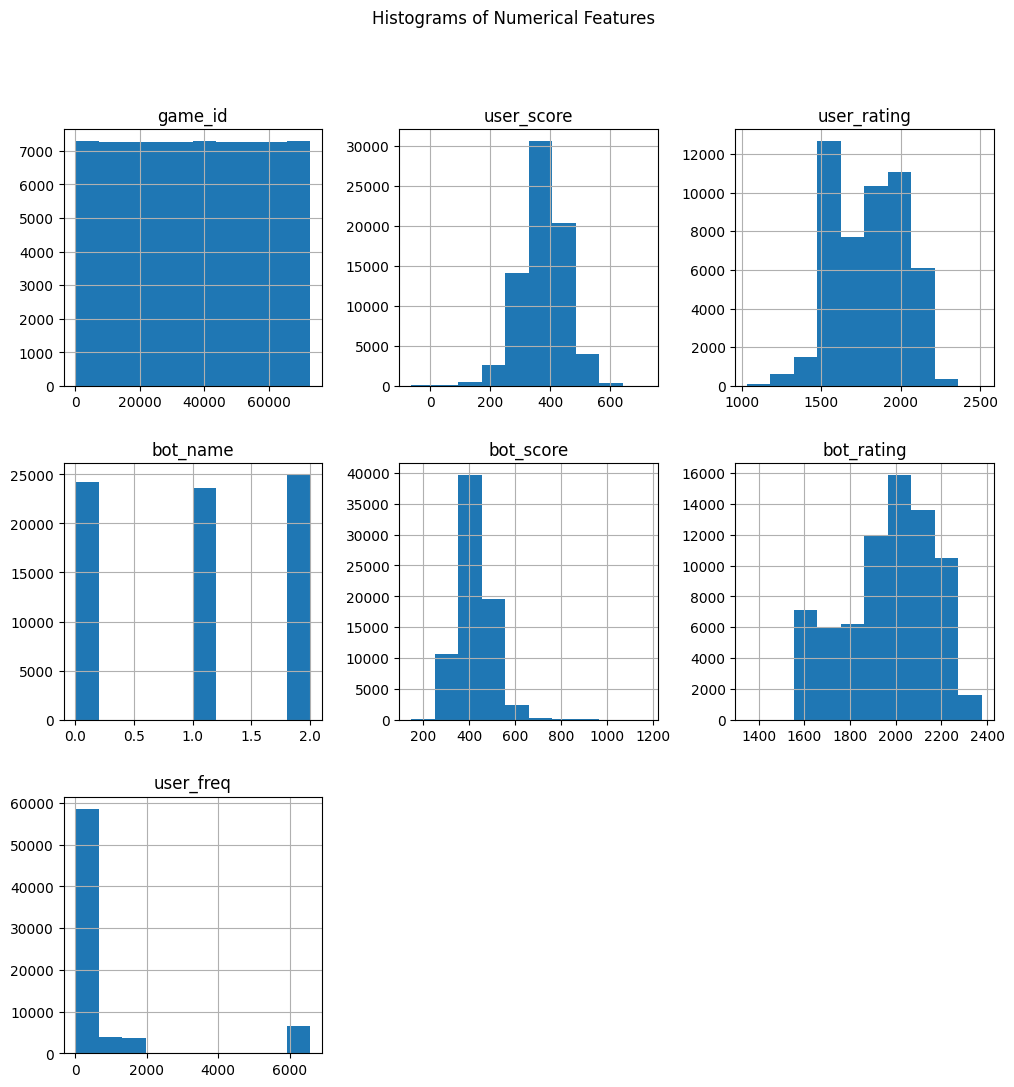

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

main_df.hist(figsize=(12, 12))
plt.suptitle('Histograms of Numerical Features')
plt.show()


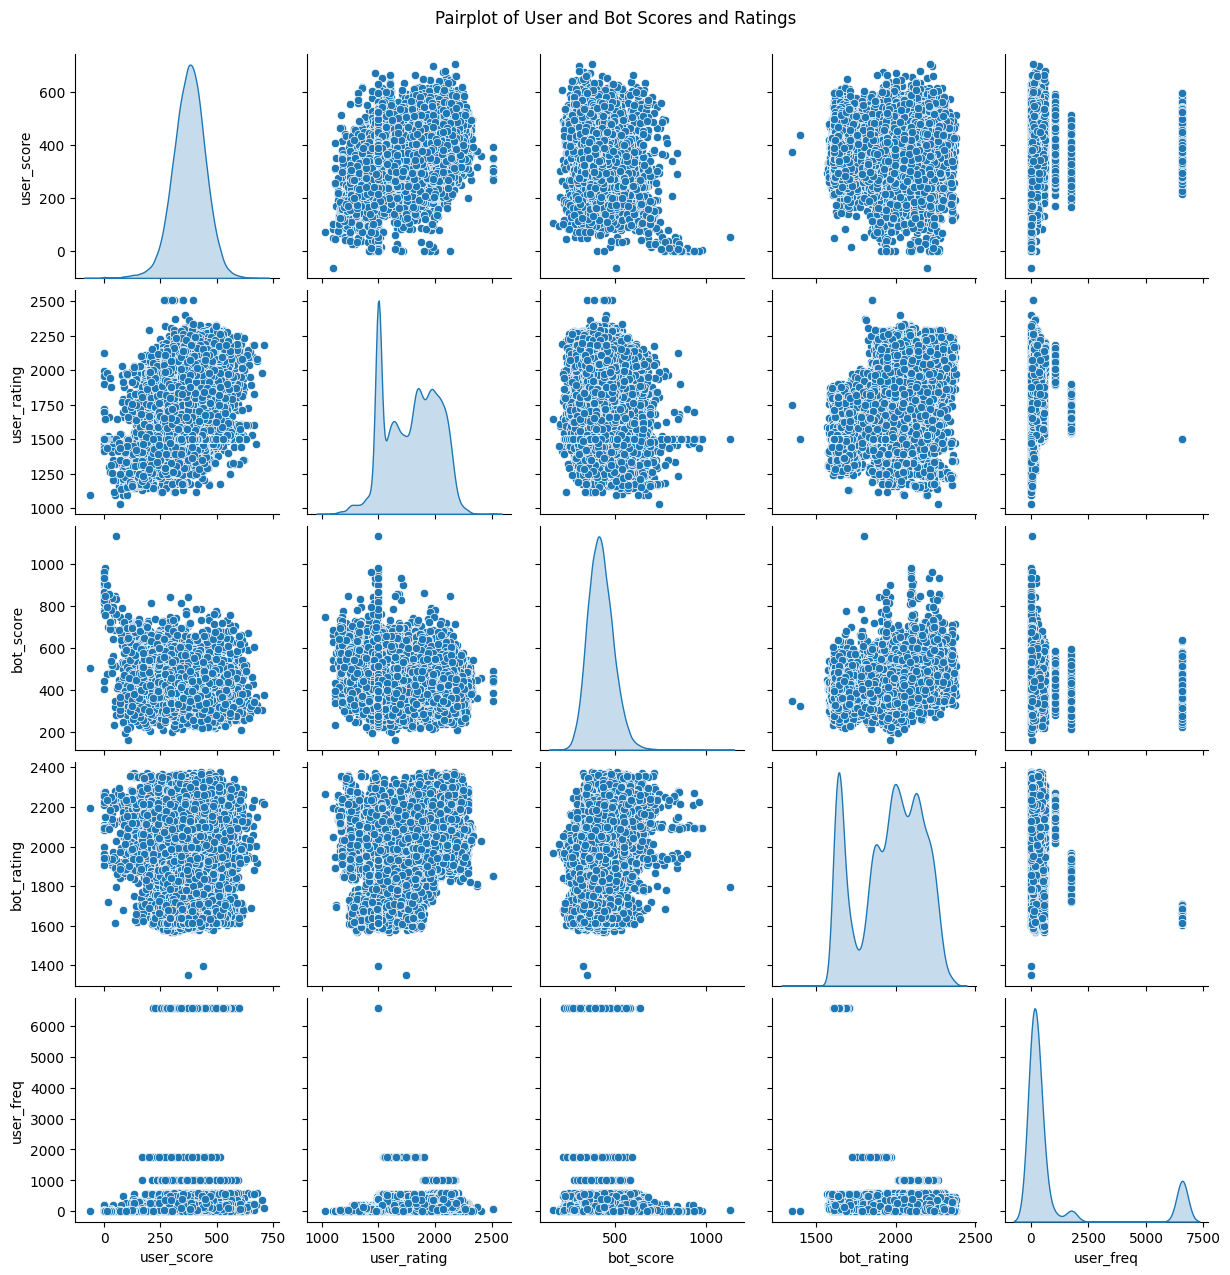

In [22]:
import seaborn as sb
import matplotlib.pyplot as plt

pairplot_data = train_df[['user_score', 'user_rating', 'bot_score', 'bot_rating', 'user_freq']]

sb.pairplot(pairplot_data, diag_kind='kde')
plt.suptitle('Pairplot of User and Bot Scores and Ratings', y=1.02)
plt.show()


## Game level analysis

Time control vs Ratings

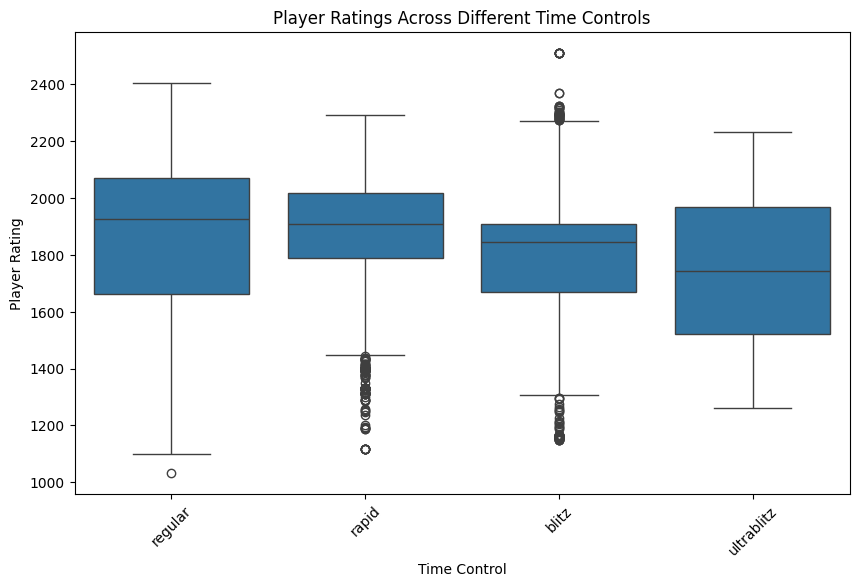

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train.merge(games, on='game_id'), x='time_control_name', y='rating')
plt.title('Player Ratings Across Different Time Controls')
plt.xlabel('Time Control')
plt.ylabel('Player Rating')
plt.xticks(rotation=45)
plt.show()


Lexicon analysis

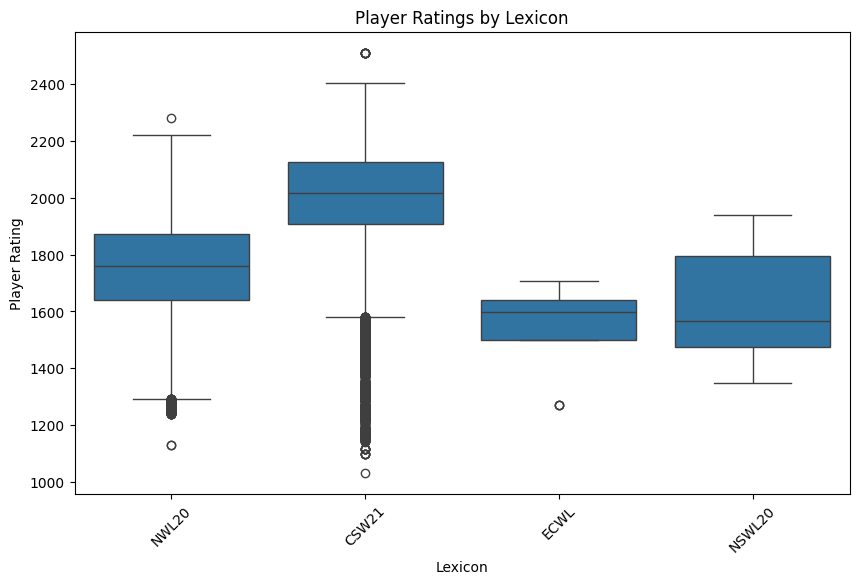

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train.merge(games, on='game_id'), x='lexicon', y='rating')
plt.title('Player Ratings by Lexicon')
plt.xlabel('Lexicon')
plt.ylabel('Player Rating')
plt.xticks(rotation=45)
plt.show()

Game duration analysis

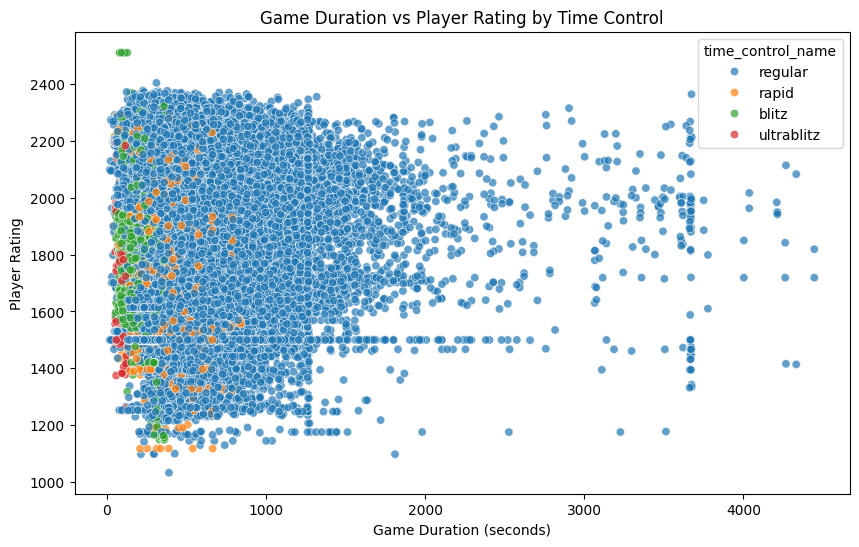

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train.merge(games, on='game_id'), x='game_duration_seconds', y='rating', hue='time_control_name', alpha=0.7)
plt.title('Game Duration vs Player Rating by Time Control')
plt.xlabel('Game Duration (seconds)')
plt.ylabel('Player Rating')
plt.show()


First move advantage??

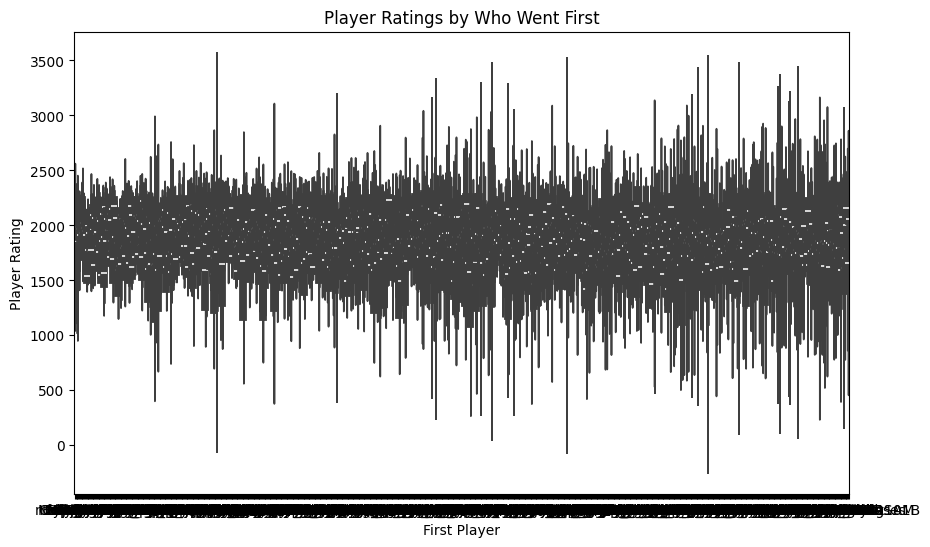

In [26]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=train.merge(games, on='game_id'), x='first', y='rating')
plt.title('Player Ratings by Who Went First')
plt.xlabel('First Player')
plt.ylabel('Player Rating')
plt.show()

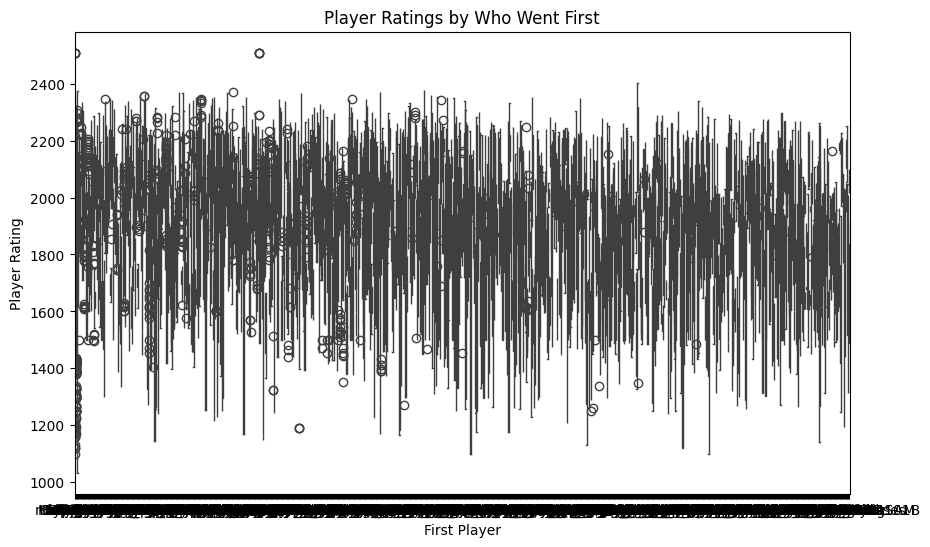

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train.merge(games, on='game_id'), x='first', y='rating')
plt.title('Player Ratings by Who Went First')
plt.xlabel('First Player')
plt.ylabel('Player Rating')
plt.show()

## Turn-Level Analysis (turns.csv)

Average Points per Turn

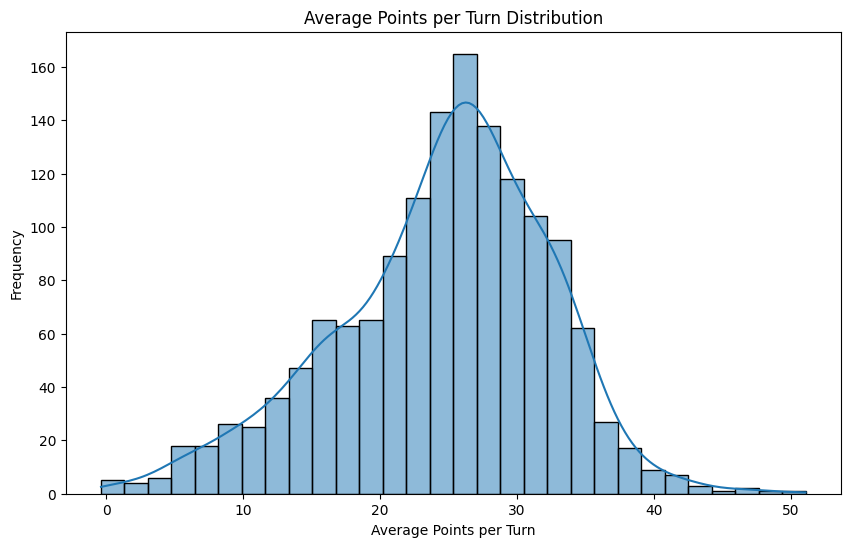

In [28]:
avg_points_per_turn = turns.groupby('nickname')['points'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.histplot(avg_points_per_turn['points'], bins=30, kde=True)
plt.title('Average Points per Turn Distribution')
plt.xlabel('Average Points per Turn')
plt.ylabel('Frequency')
plt.show()

turn type distribution

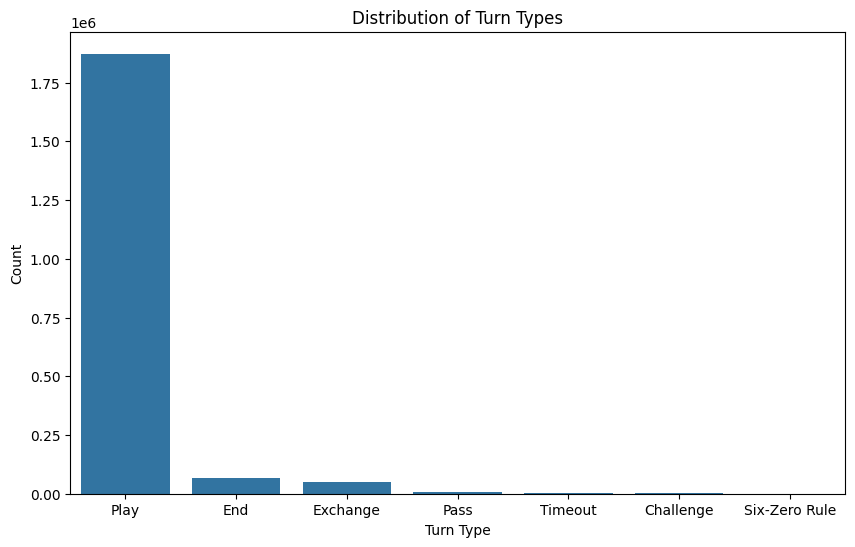

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(data=turns, x='turn_type', order=turns['turn_type'].value_counts().index)
plt.title('Distribution of Turn Types')
plt.xlabel('Turn Type')
plt.ylabel('Count')
plt.show()

Score progression

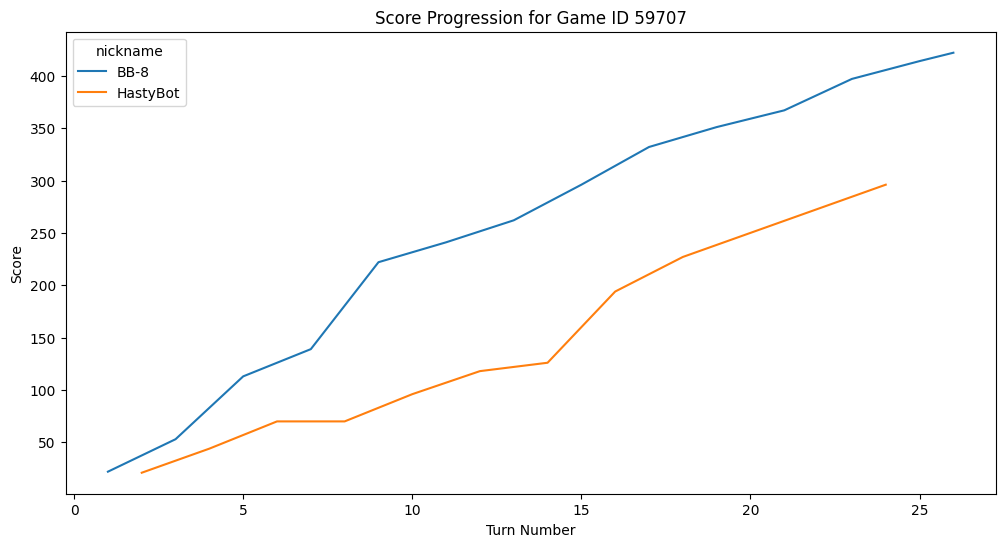

In [30]:
sample_game_id = turns['game_id'].sample(1).values[0]
sample_game_turns = turns[turns['game_id'] == sample_game_id]
plt.figure(figsize=(12, 6))
sns.lineplot(data=sample_game_turns, x='turn_number', y='score', hue='nickname')
plt.title(f'Score Progression for Game ID {sample_game_id}')
plt.xlabel('Turn Number')
plt.ylabel('Score')
plt.show()

## Player Strategy Analysis

Passes and Exchanges Analysis

In [31]:
# Passes and Exchanges Analysis
pass_counts = turns[turns['turn_type'] == 'Pass'].groupby('nickname')['turn_type'].count().reset_index(name='pass_count')
exchange_counts = turns[turns['turn_type'] == 'Exchange'].groupby('nickname')['turn_type'].count().reset_index(name='exchange_count')

Merge with player ratings

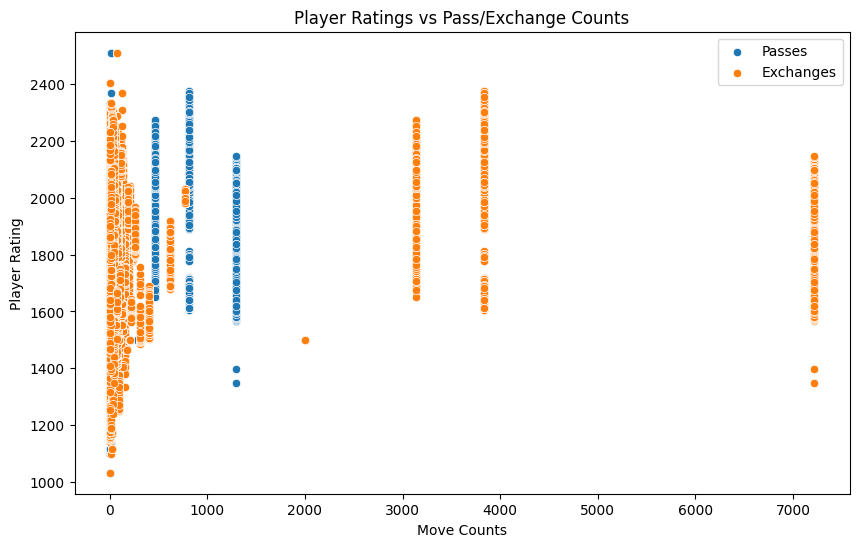

In [32]:
strategy_counts = pass_counts.merge(exchange_counts, on='nickname', how='outer').fillna(0)
strategy_ratings = strategy_counts.merge(train[['nickname', 'rating']], on='nickname')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=strategy_ratings, x='pass_count', y='rating', label='Passes')
sns.scatterplot(data=strategy_ratings, x='exchange_count', y='rating', label='Exchanges')
plt.title('Player Ratings vs Pass/Exchange Counts')
plt.xlabel('Move Counts')
plt.ylabel('Player Rating')
plt.legend()
plt.show()

Bingos

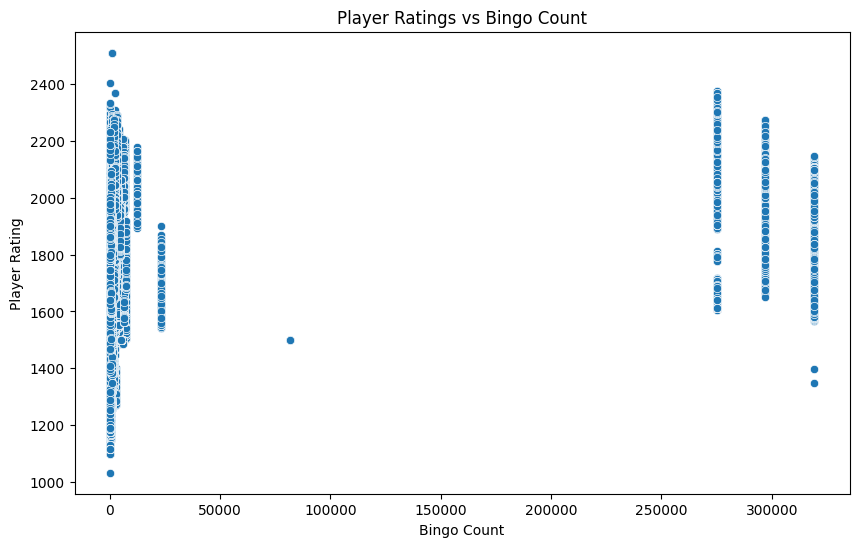

In [33]:
turns['is_bingo'] = turns['rack'].str.len() == 7
bingos = turns[turns['is_bingo']].groupby('nickname')['is_bingo'].count().reset_index(name='bingo_count')
bingos_ratings = bingos.merge(train[['nickname', 'rating']], on='nickname')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=bingos_ratings, x='bingo_count', y='rating')
plt.title('Player Ratings vs Bingo Count')
plt.xlabel('Bingo Count')
plt.ylabel('Player Rating')
plt.show()

## Game Outcomes Analysis

Winner and Rating Differences

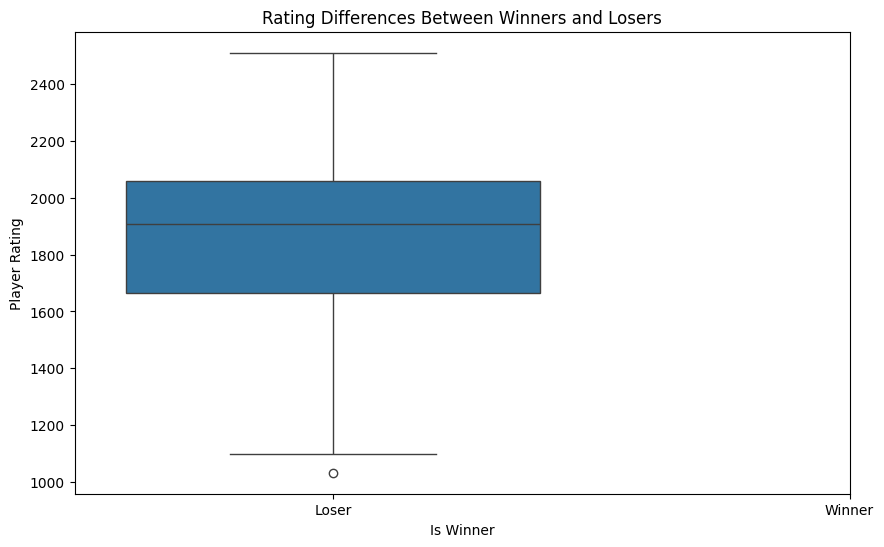

In [34]:
game_outcomes = train.merge(games[['game_id', 'winner']], on='game_id')
game_outcomes['is_winner'] = game_outcomes['nickname'] == game_outcomes['winner']
plt.figure(figsize=(10, 6))
sns.boxplot(data=game_outcomes, x='is_winner', y='rating')
plt.title('Rating Differences Between Winners and Losers')
plt.xlabel('Is Winner')
plt.ylabel('Player Rating')
plt.xticks([0, 1], ['Loser', 'Winner'])
plt.show()



Rated vs Casual

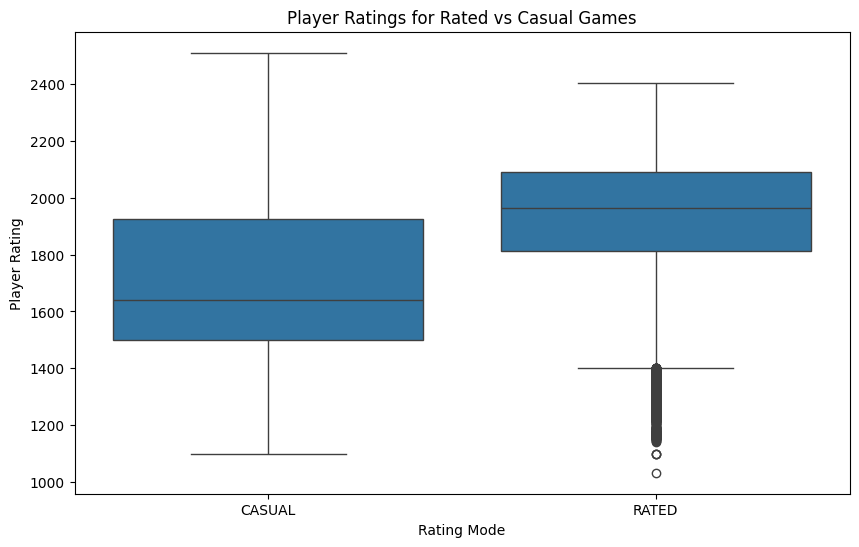

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train.merge(games, on='game_id'), x='rating_mode', y='rating')
plt.title('Player Ratings for Rated vs Casual Games')
plt.xlabel('Rating Mode')
plt.ylabel('Player Rating')
plt.show()

## Relationship between Final Scores and Ratings

Score vs. Rating Correlation

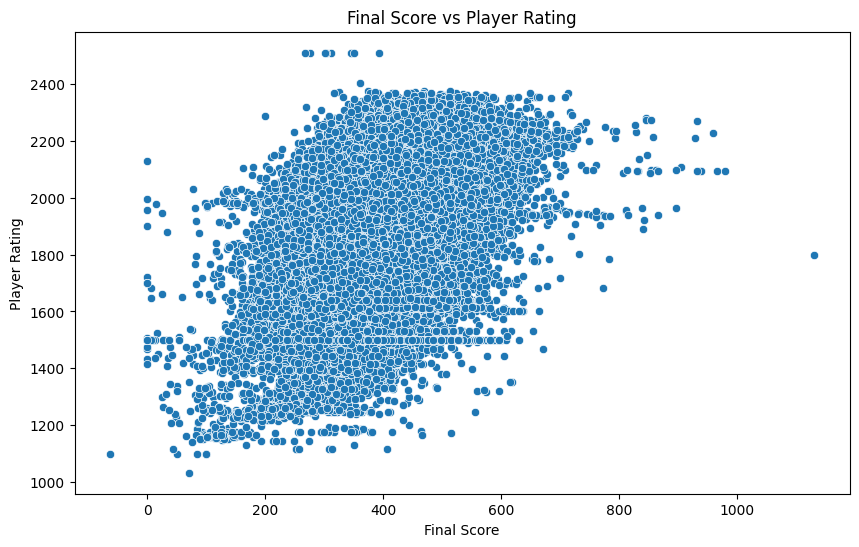

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train, x='score', y='rating')
plt.title('Final Score vs Player Rating')
plt.xlabel('Final Score')
plt.ylabel('Player Rating')
plt.show()

Score differences

<ipython-input-37-7002cfa6f8f9>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  game_scores = train.groupby('game_id').apply(lambda x: x['score'].max() - x['score'].min()).reset_index(name='score_diff')


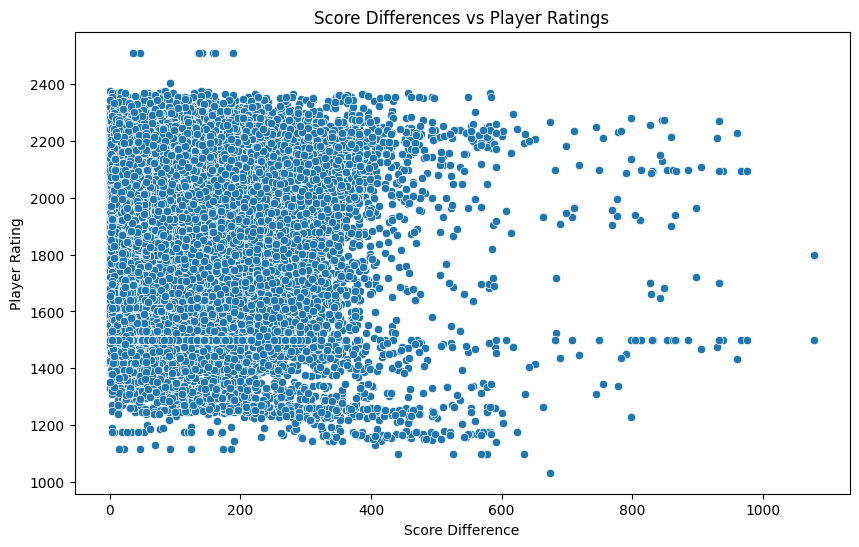

In [37]:
game_scores = train.groupby('game_id').apply(lambda x: x['score'].max() - x['score'].min()).reset_index(name='score_diff')
game_scores_ratings = game_scores.merge(train[['game_id', 'rating']], on='game_id')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=game_scores_ratings, x='score_diff', y='rating')
plt.title('Score Differences vs Player Ratings')
plt.xlabel('Score Difference')
plt.ylabel('Player Rating')
plt.show()

<Axes: >

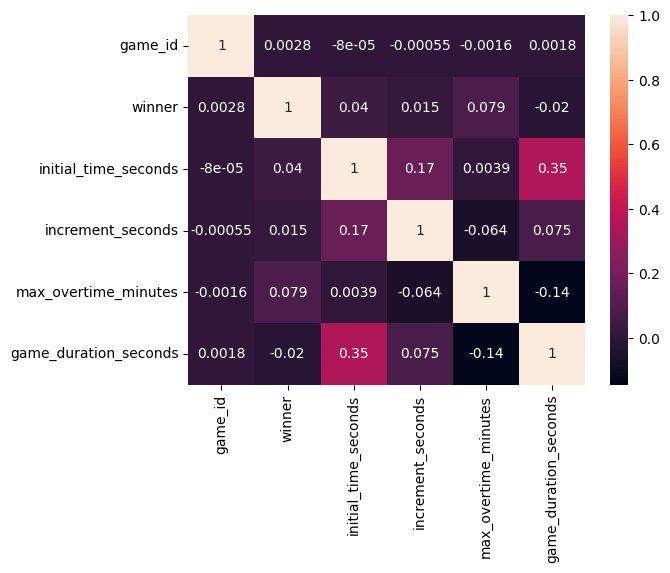

In [38]:
corr = games.select_dtypes(include='number').corr()
sns.heatmap(corr,annot=True)


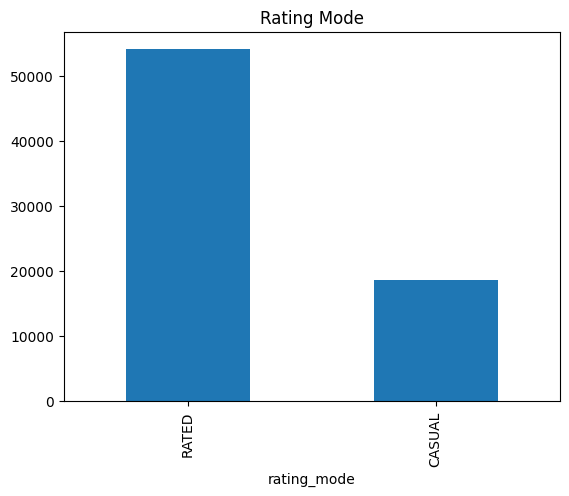

In [39]:
games["rating_mode"].value_counts().plot.bar(title='Rating Mode');

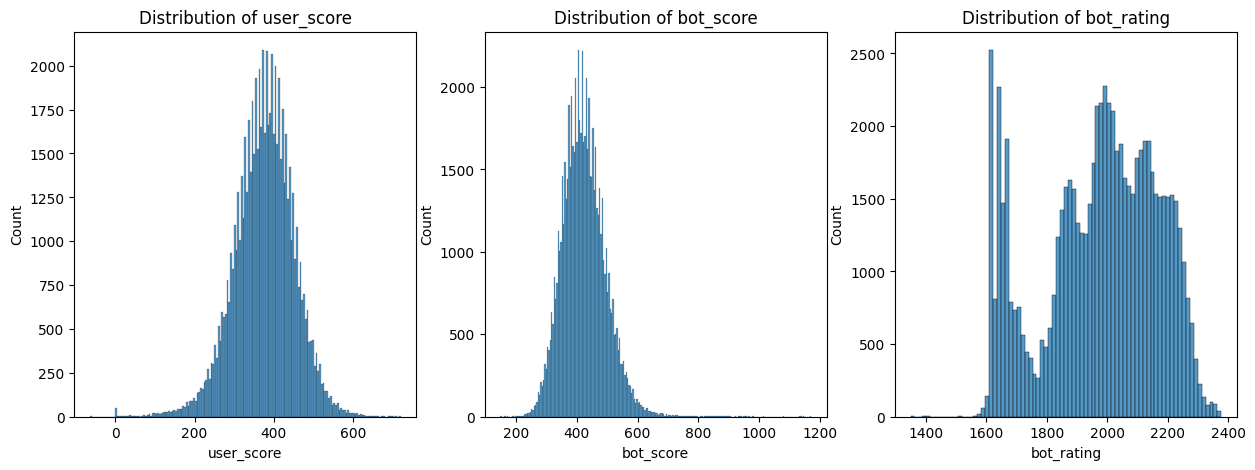

In [40]:

fig, axes = plt.subplots(1, 3, figsize=(15, 5) )
ax = axes.flatten()
sns.histplot(ax = axes[0], x = main_df["user_score"],).set(title = "Distribution of user_score");
sns.histplot(ax = axes[1], x = main_df["bot_score"],).set(title = "Distribution of bot_score");
sns.histplot(ax = axes[2], x = main_df["bot_rating"],).set(title = "Distribution of bot_rating");


# Feature Engineering

## 1. Calculate average moves per game

In [41]:
avg_moves = turns.groupby('game_id')['move'].count().reset_index()
avg_moves = avg_moves.rename(columns={'move': 'avg_moves_per_game'})
main_df = pd.merge(main_df, avg_moves, on='game_id', how='left')

## 2. Calculate average score per move

In [42]:
turn_scores = turns.groupby('game_id')['score'].mean().reset_index()
turn_scores = turn_scores.rename(columns={'score': 'avg_score_per_turn'})
main_df = pd.merge(main_df, turn_scores, on='game_id', how='left')

## 3. Use game-related metadata for each game

In [43]:
game_metadata = games[['game_id', 'game_duration_seconds', 'winner']].copy()
main_df = pd.merge(main_df, game_metadata, on='game_id', how='left')

## 4. Derive additional statistics if present in turns or games

In [44]:
turn_duration = turns.groupby('game_id')['points'].mean().reset_index()  # Example feature
turn_duration = turn_duration.rename(columns={'points': 'avg_points_per_turn'})  # Rename for clarity
main_df = pd.merge(main_df, turn_duration, on='game_id', how='left')

In [45]:
main_df.head()

,game_id,user_name,user_score,user_rating,bot_name,bot_score,bot_rating,user_freq,avg_moves_per_game,avg_score_per_turn,game_duration_seconds,winner,avg_points_per_turn
0,1,stevy,429,1500.0,0,335,1637.0,410,27,220.740741,674.844274,1,28.296296
1,2,Super,488,NaN,0,401,2000.0,140,26,257.807692,364.214418,1,34.192308
2,3,davidavid,440,1811.0,0,318,2071.0,254,27,194.814815,492.268262,1,28.074074
3,4,Inandoutworker,119,1473.0,0,478,1936.0,205,29,159.310345,350.861141,0,20.586207
4,5,stevy,325,1500.0,2,427,1844.0,410,31,224.096774,642.688722,0,24.258065


***
# Model creation

Split data into train and test

In [46]:
train_df = main_df[~main_df['user_rating'].isna()].reset_index(drop=True)
test_df = main_df[main_df['user_rating'].isna()].reset_index(drop=True)

### Evaluation function

In [47]:
def evaluate_regression_models(model, model_name, X, y, n_folds=5):
    score_details = {
        "model": [],
        "R2": [],
        "RMSE": [],
        "MAE": [],
        "MAPE": [],
    }
    r2_scores = []
    rmse_scores = []
    mae_scores = []
    mape_scores = []

    kf = KFold(n_splits=n_folds)
    start_time = time.time()

    for train_indices, val_indices in kf.split(X):
        X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
        y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]

        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        val_predictions = model.predict(X_val)

        # Append scores
        r2_scores.append(r2_score(y_val, val_predictions))
        rmse_scores.append(root_mean_squared_error(y_val, val_predictions))
        mae_scores.append(mean_absolute_error(y_val, val_predictions))
        mape_scores.append(np.mean(np.abs((y_val - val_predictions) / y_val)) * 100)

        # Store average scores
        score_details["model"].append(model_name)
        score_details["R2"].append(np.mean(r2_scores))
        score_details["RMSE"].append(np.mean(rmse_scores))
        score_details["MAE"].append(np.mean(mae_scores))
        score_details["MAPE"].append(np.mean(mape_scores))

    # Create DataFrame from score details
    score_summary_df = pd.DataFrame(score_details)
    average_scores = score_summary_df.drop(columns=["model"]).mean()
    print(average_scores)
    return score_summary_df

In [48]:
# Prepare training data
X_train = train_df.drop(["user_name", "user_rating"], axis=1)
y_train = train_df["user_rating"].copy()

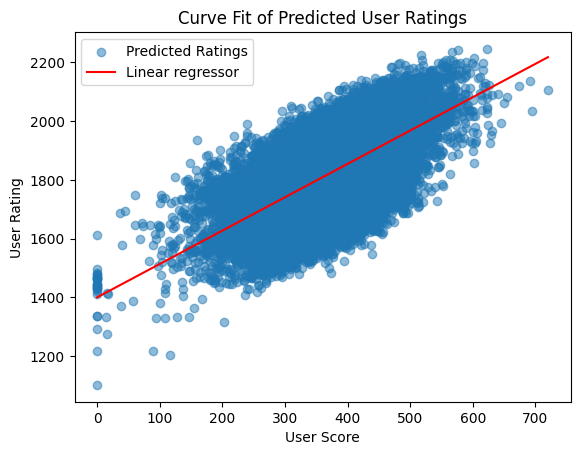

In [49]:
#Training using Linear Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
model = LinearRegression()
model.fit(X_train, y_train)
test_df["user_rating"] = model.predict(test_df.drop(["user_name", "user_rating"], axis=1))
linear_pred = test_df[["user_score", "user_rating"]]
linear_pred = linear_pred.rename(columns={"user_rating": "rating"})
linear_pred.to_csv("linear.csv", index=False)
linear = pd.read_csv("linear.csv")
x = linear["user_score"]
y = linear["rating"]
p = Polynomial.fit(x, y, deg=1)

# Generate x and y values for the curve
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = p(x_vals)

# Plot
plt.scatter(x, y, alpha=0.5, label="Predicted Ratings")
plt.plot(x_vals, y_vals, color="red", label="Linear regressor")
plt.xlabel("User Score")
plt.ylabel("User Rating")
plt.title("Curve Fit of Predicted User Ratings")
plt.legend()
plt.show()

In [50]:
score_summary_df = evaluate_regression_models(model, "linear_regression", X_train, y_train, n_folds=5)

R2        0.555358
RMSE    153.260169
MAE     113.565201
MAPE      6.538576
dtype: float64


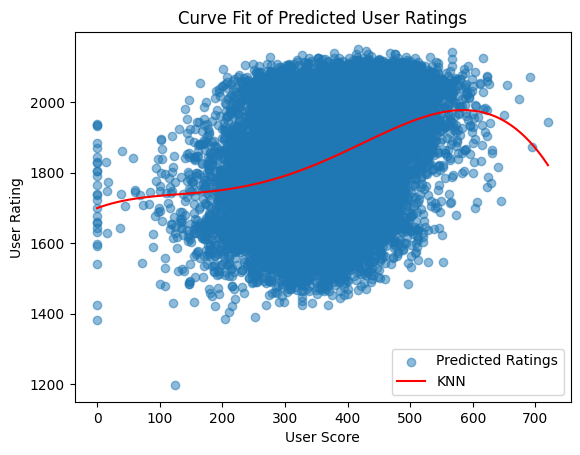

In [51]:
#Using KNN
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
model.fit(X_train, y_train)
test_df["user_rating"] = model.predict(test_df.drop(["user_name", "user_rating"], axis=1))
KNN_pred = test_df[["user_score", "user_rating"]]
KNN_pred = KNN_pred.rename(columns={"user_rating": "rating"})
KNN_pred.to_csv("KNN.csv", index=False)
KNN = pd.read_csv("KNN.csv")
x = KNN["user_score"]
y = KNN["rating"]
p = Polynomial.fit(x, y, deg=4)

# Generate x and y values for the curve
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = p(x_vals)

# Plot
plt.scatter(x, y, alpha=0.5, label="Predicted Ratings")
plt.plot(x_vals, y_vals, color="red", label="KNN")
plt.xlabel("User Score")
plt.ylabel("User Rating")
plt.title("Curve Fit of Predicted User Ratings")
plt.legend()
plt.show()

In [52]:
score_summary_df = evaluate_regression_models(model, "k_neighbours_regressor", X_train, y_train, n_folds=5)

R2        0.163680
RMSE    209.218241
MAE     157.085034
MAPE      8.676021
dtype: float64


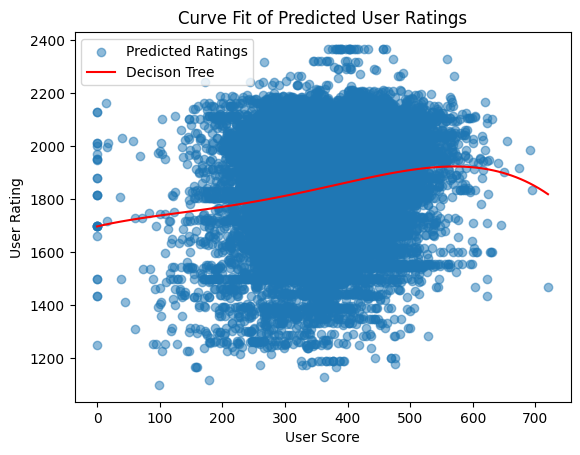

In [53]:
#Using DecisonTree Regressor
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
test_df["user_rating"] = model.predict(test_df.drop(["user_name", "user_rating"], axis=1))
DecisonTree_pred = test_df[["user_score", "user_rating"]]
DecisonTree_pred = DecisonTree_pred.rename(columns={"user_rating": "rating"})
DecisonTree_pred.to_csv("DecisonTree.csv", index=False)
DecisonTree = pd.read_csv("DecisonTree.csv")
x = DecisonTree["user_score"]
y = DecisonTree["rating"]
p = Polynomial.fit(x, y, deg=4)

# Generate x and y values for the curve
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = p(x_vals)

# Plot
plt.scatter(x, y, alpha=0.5, label="Predicted Ratings")
plt.plot(x_vals, y_vals, color="red", label="Decison Tree")
plt.xlabel("User Score")
plt.ylabel("User Rating")
plt.title("Curve Fit of Predicted User Ratings")
plt.legend()
plt.show()

In [54]:
score_summary_df = evaluate_regression_models(model, "decision_tree_regressor", X_train, y_train, n_folds=5)

R2        0.713658
RMSE    122.816930
MAE      65.966773
MAPE      3.731457
dtype: float64


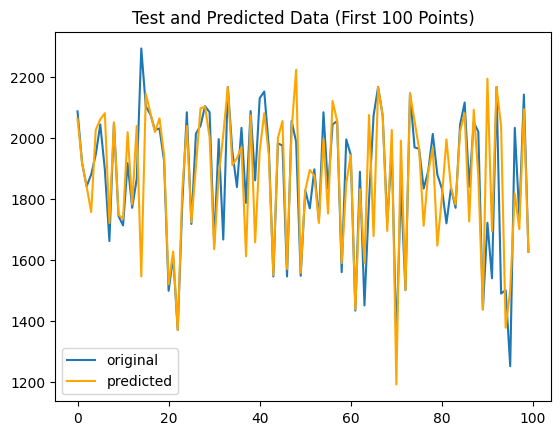

In [55]:
y_test = test_df["user_rating"]
y_pred = model.predict(test_df.drop(["user_name", "user_rating"], axis=1))
# Use only the first 100 data points
y_test_100 = y_test[:100]
y_pred_100 = y_pred[:100]
x_ax_100 = range(100)

# Plot actual and predicted values for the first 100 points
plt.plot(x_ax_100, y_test_100, label="original")
plt.plot(x_ax_100, y_pred_100, label="predicted", color='orange')
plt.title("Test and Predicted Data (First 100 Points)")
plt.legend()
plt.show()

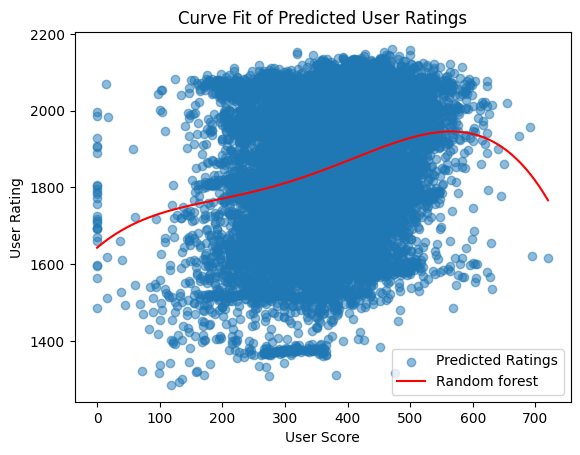

In [56]:
#Using Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
test_df["user_rating"] = model.predict(test_df.drop(["user_name", "user_rating"], axis=1))
Randomforest_pred = test_df[["user_score", "user_rating"]]
Randomforest_pred = Randomforest_pred.rename(columns={"user_rating": "rating"})
Randomforest_pred.to_csv("Randomforest.csv", index=False)
Randomforest = pd.read_csv("Randomforest.csv")
x = Randomforest["user_score"]
y = Randomforest["rating"]
p = Polynomial.fit(x, y, deg=4)

# Generate x and y values for the curve
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = p(x_vals)

# Plot
plt.scatter(x, y, alpha=0.5, label="Predicted Ratings")
plt.plot(x_vals, y_vals, color="red", label="Random forest")
plt.xlabel("User Score")
plt.ylabel("User Rating")
plt.title("Curve Fit of Predicted User Ratings")
plt.legend()
plt.show()

In [57]:
score_summary_df = evaluate_regression_models(model, "random_forest_regressor", X_train, y_train, n_folds=5)

R2       0.861347
RMSE    85.575324
MAE     50.230893
MAPE     2.863279
dtype: float64


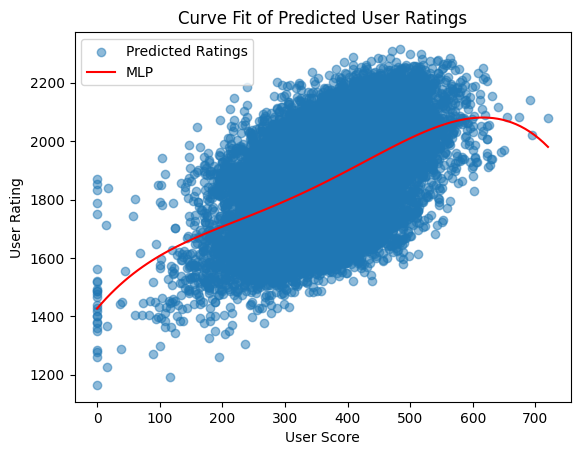

In [58]:
#Using Neural Network Regressor
from sklearn.neural_network import MLPRegressor
from functools import partial
model = partial(MLPRegressor, random_state=1, max_iter=500)
model = model(max_iter=2000, alpha=0.01, learning_rate='adaptive').fit(X_train, y_train.values.ravel())
test_df["user_rating"] = model.predict(test_df.drop(["user_name", "user_rating"], axis=1))
MLP_pred = test_df[["user_score", "user_rating"]]
MLP_pred = MLP_pred.rename(columns={"user_rating": "rating"})
MLP_pred.to_csv("MLP.csv", index=False)
MLP = pd.read_csv("MLP.csv")
x = MLP["user_score"]
y = MLP["rating"]
p = Polynomial.fit(x, y, deg=4)

# Generate x and y values for the curve
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = p(x_vals)

# Plot
plt.scatter(x, y, alpha=0.5, label="Predicted Ratings")
plt.plot(x_vals, y_vals, color="red", label="MLP")
plt.xlabel("User Score")
plt.ylabel("User Rating")
plt.title("Curve Fit of Predicted User Ratings")
plt.legend()
plt.show()

In [59]:
score_summary_df = evaluate_regression_models(model, "MLP", X_train, y_train, n_folds=5)

R2       -0.069038
RMSE    222.584199
MAE     164.899464
MAPE      9.354445
dtype: float64


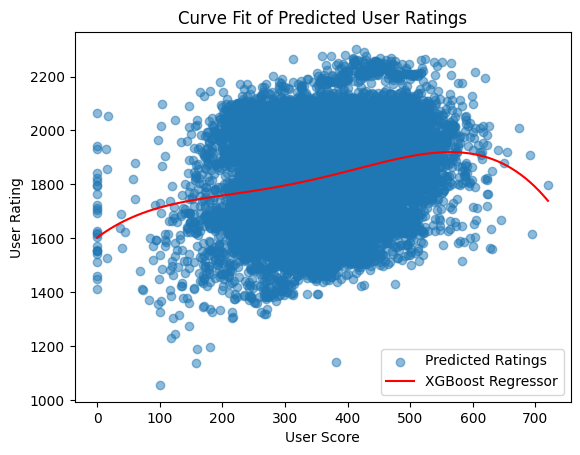

In [60]:
#Using XGBoost Regressor
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train)
test_df["user_rating"] = model.predict(test_df.drop(["user_name", "user_rating"], axis=1))
XGB_pred = test_df[["user_score", "user_rating"]]
XGB_pred = XGB_pred.rename(columns={"user_rating": "rating"})
XGB_pred.to_csv("XGB.csv", index=False)
XGB = pd.read_csv("XGB.csv")
x = XGB["user_score"]
y = XGB["rating"]
p = Polynomial.fit(x, y, deg=4)

# Generate x and y values for the curve
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = p(x_vals)

# Plot
plt.scatter(x, y, alpha=0.5, label="Predicted Ratings")
plt.plot(x_vals, y_vals, color="red", label="XGBoost Regressor")
plt.xlabel("User Score")
plt.ylabel("User Rating")
plt.title("Curve Fit of Predicted User Ratings")
plt.legend()
plt.show()

In [61]:
score_summary_df = evaluate_regression_models(model, "XGBoost Regressor", X_train, y_train, n_folds=5)

R2       0.868234
RMSE    83.421700
MAE     52.575439
MAPE     2.979499
dtype: float64


Therefore we observe highest R2 score for RandomForest Regressor

In [64]:
#Submission
submission = test_df[["game_id", "user_rating"]]
submission = submission.rename(columns={"user_rating": "rating"})
submission.to_csv("submission.csv", index=False)

from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>